In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
file_count = sum(len(files) for _, _, files in os.walk('/kaggle/input'))
print(f"Total {file_count} files found.")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Total 3264 files found.


# Brain Tumor Classification with CNN

This project focuses on classifying brain tumor images using Convolutional Neural Networks (CNN). The dataset consists of MRI images of four types of brain tumors: **no tumor**, **pituitary tumor**, **meningioma tumor**, and **glioma tumor**. We use a CNN model to classify the images into these categories.

## Project Setup

### Dataset

The dataset used in this project consists of MRI images of brain tumors. The images are stored in two directories: **Training** and **Testing**.

- **Training Set:** Contains labeled images used to train the model.
- **Testing Set:** Contains images used to evaluate the model's performance.

The labels are:
- **no_tumor**
- **pituitary_tumor**
- **meningioma_tumor**
- **glioma_tumor**

### Import Libraries
This project uses the following libraries:
- **TensorFlow/Keras**: For model building and training.
- **OpenCV**: For image processing.
- **Matplotlib/Seaborn**: For visualization.
- **Scikit-learn**: For metrics and splitting data.

In [2]:
# Required Libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Data Loading and Preprocessing

The dataset consists of images of MRI scans stored in different folders based on the tumor type. Each image is resized to a consistent size for model training. Here we load and preprocess the data, including:
- Reading images
- Resizing them to 224x224
- Normalizing pixel values
- One-hot encoding the labels

Additionally, we split the data into training, validation, and test sets for model evaluation.

In [3]:
# Loading and Preprocessing Data
dataset_path = "brain-tumor-classification-mri"
data = {
    "train": "/kaggle/input/brain-tumor-classification-mri/Training",
    "test": "/kaggle/input/brain-tumor-classification-mri/Testing"
}
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [4]:
# Function to load data and resize images
def load_data(data_path, labels, img_size=224):
    X, y = [], []
    if not os.path.exists(data_path):
        raise ValueError(f"Error: Path not found -> {data_path}")
    
    for label in labels:
        label_path = os.path.join(data_path, label)
        if not os.path.exists(label_path):
            print(f"Warning: Folder not found for label '{label}', skipping.")
            continue

        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: '{img_name}' could not be read, skipping.")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(labels.index(label))
            except Exception as e:
                print(f"Warning: Error loading '{img_name}': {e}")
    
    return np.array(X), np.array(y)

In [5]:
X_train, y_train = load_data(data["train"], labels)
X_test, y_test = load_data(data["test"], labels)

In [6]:
# Ensure 'labels' is defined
labels = ["glioma", "meningioma", "pituitary", "notumor"]
num_classes = len(labels)

# Normalize the data
X_train, X_test = X_train.astype("float32") / 255.0, X_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_train, y_test = to_categorical(y_train, num_classes), to_categorical(y_test, num_classes)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode="nearest"
)
datagen.fit(X_train)


## Model Architecture

The model is a Convolutional Neural Network (CNN) designed to classify MRI images into one of four categories. It consists of multiple convolutional layers followed by max-pooling layers. The final layers are dense layers for classification. We also use dropout for regularization.

The model is compiled using Adam optimizer for better precision in the `glioma_tumor` class.

In [8]:
model = Sequential([
    Input(shape=(224, 224, 3)), 
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [9]:
# I prefer the Adam optimizer because it provides higher precision for the glioma_tumor class. 
# With this optimizer, the overall accuracy of the model is also higher.
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# However, if you are aiming for a more balanced model, the RMSprop optimizer also yields good results, 
# but the overall accuracy and precision might be slightly lower.
# model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

## Model Training

The model is trained using the training dataset, with data augmentation applied for better generalization. The validation dataset is used to monitor the model's performance during training. We use categorical cross-entropy loss and accuracy as the metrics.

In [11]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.4681 - loss: 1.2831 - val_accuracy: 0.7247 - val_loss: 0.6606
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7095 - loss: 0.7432 - val_accuracy: 0.7700 - val_loss: 0.5358
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7673 - loss: 0.5413 - val_accuracy: 0.8206 - val_loss: 0.4184
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8462 - loss: 0.4068 - val_accuracy: 0.8589 - val_loss: 0.3532
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8879 - loss: 0.3046 - val_accuracy: 0.8606 - val_loss: 0.3759
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9136 - loss: 0.2132 - val_accuracy: 0.8711 - val_loss: 0.3210
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9394 - loss: 0.1598 - val_accuracy: 0.8902 - val_loss: 0.3010
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9456 - loss: 0.1462 - val_accuracy: 0.9024 -

## Model Evaluation and Results

After training the model, we evaluate its performance on the test set. The results include:
- Test loss and accuracy
- Confusion matrix
- Classification report

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8507 - loss: 1.7981
Test Loss: 5.3070
Test Accuracy: 0.7005


In [13]:
# Confusion Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


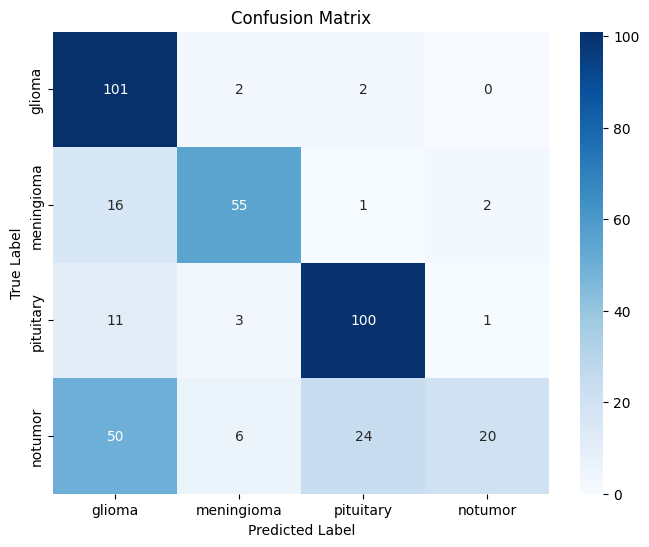

In [14]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [15]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.57      0.96      0.71       105
  meningioma       0.83      0.74      0.79        74
   pituitary       0.79      0.87      0.83       115
     notumor       0.87      0.20      0.33       100

    accuracy                           0.70       394
   macro avg       0.76      0.69      0.66       394
weighted avg       0.76      0.70      0.66       394



### Model Predictions on Test Data
Below, we visualize 10 randomly selected test images along with their true labels and predicted labels. Green titles indicate correct predictions, while red titles indicate incorrect predictions.

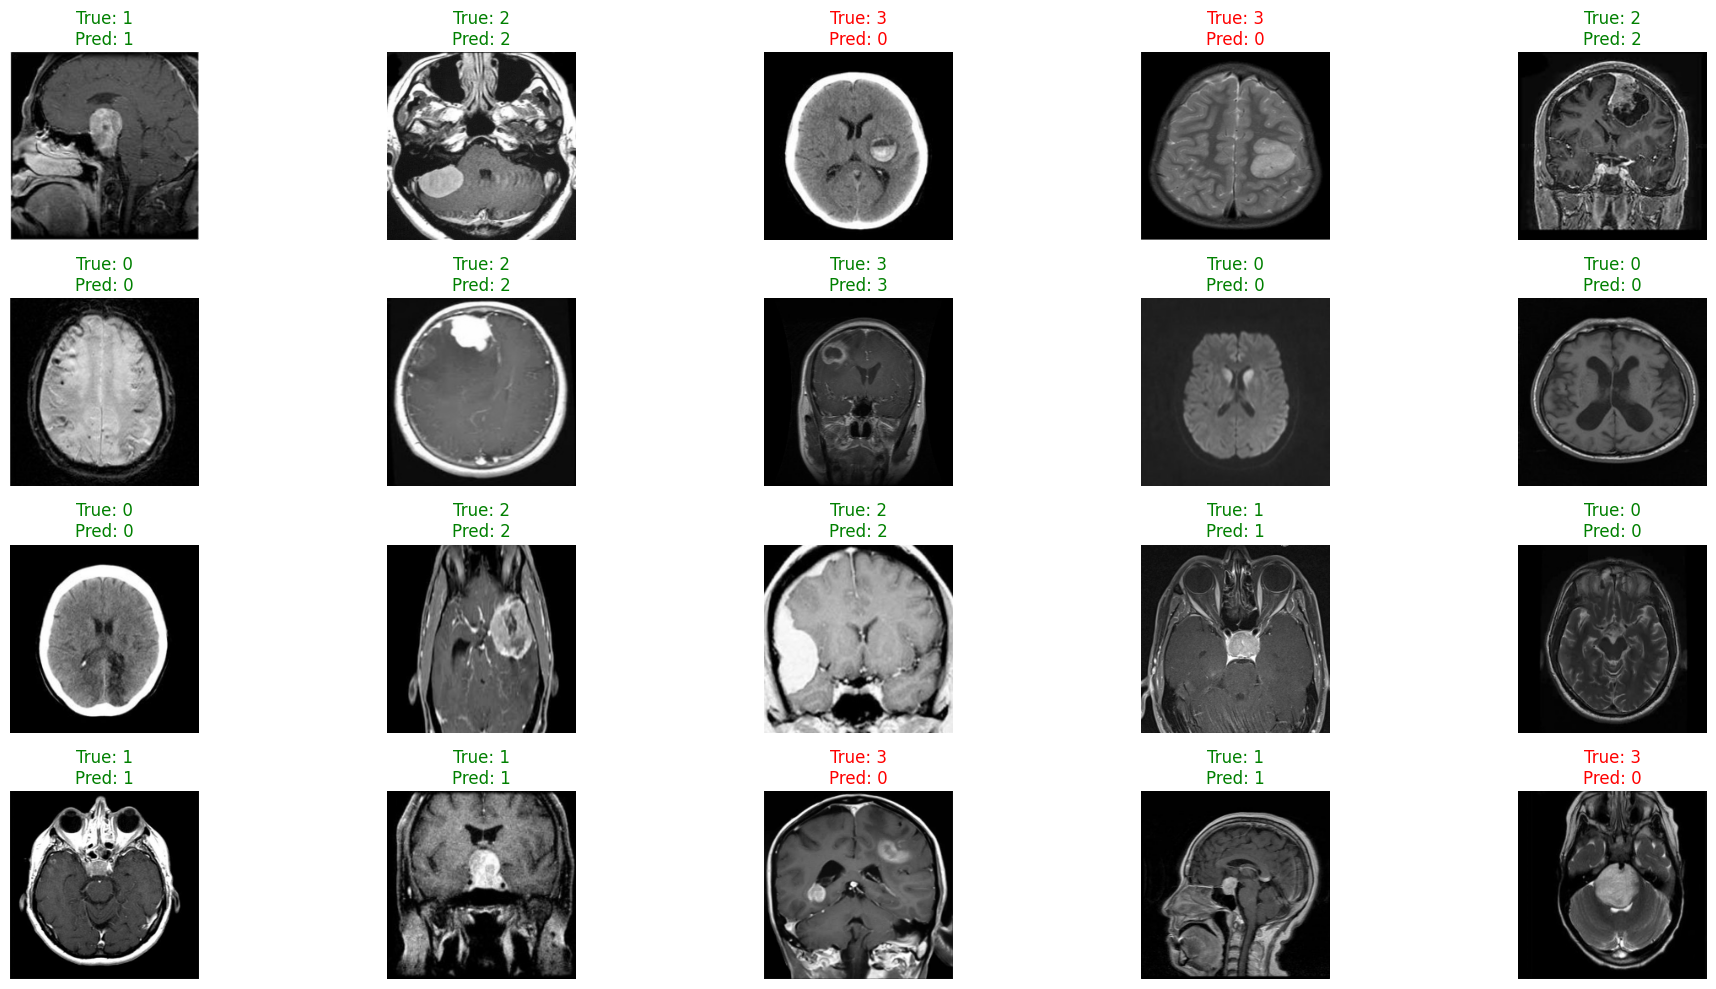

In [16]:
random_indices = np.random.choice(len(X_test), 20, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_label = y_true[idx]
    pred_label = y_pred_classes[idx]
    
    plt.subplot(4, 5, i + 1)  # 4 satır, 5 sütun olacak şekilde düzenle
    plt.imshow(img, cmap="gray")  # Renkli görüntü ise cmap kaldır
    plt.axis("off")
    
    # Doğru tahminler yeşil, yanlışlar kırmızı renkte olacak
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()